<a href="https://colab.research.google.com/github/jamartinezv2023/SO-Lab3-20252/blob/main/analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 3 – Pthreads**
## **Cálculo Paralelo de π y Generación de Fibonacci**

**Autor:** José Alfredo Martínez Valdés  
**Correo:** jose.martinez7@udea.edu.co  
**Profesor:** Henry Alberto Arcila Ramírez  
**Asignatura:** Sistemas Operativos y Laboratorios  
**Repositorio:** https://github.com/jamartinezv2023/SO-Lab3-20252

**Enlace al Video con la presentación:** https://youtu.be/yp6etHmfxMo
## Análisis de rendimiento y diseño de soluciones

Este notebook (`analisis.ipynb`) contiene el análisis completo solicitado para las dos partes del laboratorio:

1. **Cálculo de π (pi) con implementación serial y paralela usando Pthreads.**  
2. **Generación de la sucesión de Fibonacci con paso de parámetros a un hilo trabajador.**

---
---


## Código `pi.c` (versión serial)
```c
#include <math.h>
#include "timer.h"

double f(double x) { return 4.0 / (1.0 + x*x); }

double CalcPi(int n){
    const double fH=1.0/(double)n;
    double fSum=0.0,fX;
    for(int i=0;i<n;i++){ fX=fH*(i+0.5); fSum+=f(fX); }
    return fH*fSum;
}

int main(int argc,char**argv){
    int n=atoi(argv[1]);
    double t0=GetTime();
    double pi=CalcPi(n);
    double t1=GetTime();
    printf("PI = %.12f\n",pi);
    printf("Tiempo serial = %f segundos\n", t1-t0);
}
```

## Código `pi_p.c` (paralelo con Pthreads)
```c
#include <pthread.h>
#include <math.h>
#include "timer.h"

typedef struct {
    int inicio, fin;
    double fH;
    double suma_local;
} datos_hilo;

double f(double x){ return 4.0/(1.0+x*x); }

void* tarea(void*arg){
    datos_hilo *d=(datos_hilo*)arg;
    double sum=0.0;
    for(int i=d->inicio;i<d->fin;i++){
        double x=d->fH*(i+0.5);
        sum+=f(x);
    }
    d->suma_local=sum;
    return NULL;
}

int main(int argc,char**argv){
    int n=atoi(argv[1]);
    int T=atoi(argv[2]);
    double fH=1.0/(double)n;

    pthread_t hilos[T];
    datos_hilo datos[T];

    int bloque=n/T;

    double t0=GetTime();

    for(int i=0;i<T;i++){
        datos[i].inicio=i*bloque;
        datos[i].fin=(i==T-1? n : (i+1)*bloque);
        datos[i].fH=fH;
        pthread_create(&hilos[i],NULL,tarea,&datos[i]);
    }

    double suma_total=0.0;
    for(int i=0;i<T;i++){
        pthread_join(hilos[i],NULL);
        suma_total+=datos[i].suma_local;
    }

    double pi=fH*suma_total;
    double t1=GetTime();

    printf("PI = %.12f\n", pi);
    printf("Tiempo paralelo = %f segundos\n", t1-t0);
}
```

## Código `fibonacci.c`
```c
#include <pthread.h>
#include <stdlib.h>
#include <stdio.h>

typedef struct {
    long *arr;
    int N;
} datos;

void* generar(void*arg){
    datos *d=(datos*)arg;
    long *a=d->arr;
    int N=d->N;

    if(N>0) a[0]=0;
    if(N>1) a[1]=1;
    for(int i=2;i<N;i++) a[i]=a[i-1]+a[i-2];

    return NULL;
}

int main(int argc,char**argv){
    int N=atoi(argv[1]);
    long *arr=malloc(sizeof(long)*N);

    pthread_t hilo;
    datos d={arr,N};

    pthread_create(&hilo,NULL,generar,&d);
    pthread_join(hilo,NULL);

    for(int i=0;i<N;i++) printf("%ld\n", arr[i]);
}
```

# Sección 1: Análisis de π

En esta sección se analizan los resultados de la ejecución de los programas:

- `./pi_s`  — versión **serial**.  
- `./pi_p`  — versión **paralela** con Pthreads.

En todos los casos se utilizó el mismo número de iteraciones:

\[ n = 2\ 000\ 000\ 000 \]

Las mediciones de tiempo se tomaron a partir de la salida de los programas y se expresan en **segundos**.


## 1.1 Evaluación de $T_s$ (Tiempo Serial)

La ejecución del programa serial fue:

```bash
$ ./pi_s 2000000000
PI = 3.141592653590
Tiempo serial = 13.338031 segundos
```

Por lo tanto, el tiempo serial medido es:

\[ T_s = 13.338031 \text{ segundos} \]


## 1.2 Evaluación de $T_p$ (Tiempo Paralelo)

El programa paralelo se ejecutó con el mismo valor de **n**, variando el número de hilos **N**:

```bash
$ ./pi_p 2000000000 1
$ ./pi_p 2000000000 2
$ ./pi_p 2000000000 4
$ ./pi_p 2000000000 8
$ ./pi_p 2000000000 16
$ ./pi_p 2000000000 32
$ ./pi_p 2000000000 48
```

A partir de la salida del programa, los tiempos paralelos medidos fueron:

- Para **N = 1**: `Tiempo paralelo = 9.808235 segundos`  
- Para **N = 2**: `Tiempo paralelo = 4.915907 segundos`  
- Para **N = 4**: `Tiempo paralelo = 5.377329 segundos`  
- Para **N = 8**: `Tiempo paralelo = 3.086781 segundos`  
- Para **N = 16**: `Tiempo paralelo = 4.400215 segundos`  
- Para **N = 32**: `Tiempo paralelo = 49.486522 segundos`  
- Para **N = 48**: `Tiempo paralelo = 37.850396 segundos`

Obsérvese que el número de hilos se llevó más allá de $2\times$ el número de núcleos lógicos para analizar también el comportamiento cuando hay **sobresuscripción** de hilos.


## 1.3 Tabla de resultados: $T_p(N)$, *Speedup* y *Eficiencia*

En esta sección se construye una tabla con las métricas pedidas:

- $T_p(N)$: tiempo paralelo con **N** hilos.  
- **Speedup**:  
  \[ \text{Speedup}(N) = \dfrac{T_s}{T_p(N)} \]  
- **Eficiencia**:  
  \[ \text{Eficiencia}(N) = \dfrac{\text{Speedup}(N)}{N} \]


In [ ]:
import pandas as pd

# Tiempo serial medido
Ts = 13.338031

# Resultados experimentales de Tp(N)
data = {
    "N": [1, 2, 4, 8, 16, 32, 48],
    "Tp (s)": [9.808235, 4.915907, 5.377329, 3.086781, 4.400215, 49.486522, 37.850396],
}

df = pd.DataFrame(data)
df["Speedup"] = Ts / df["Tp (s)"]
df["Eficiencia"] = df["Speedup"] / df["N"]

df

,N,Tp (s),Speedup,Eficiencia
0,1,9.808235,1.359881,1.359881
1,2,4.915907,2.713239,1.356620
2,4,5.377329,2.480419,0.620105
3,8,3.086781,4.321016,0.540127
4,16,4.400215,3.031223,0.189451
5,32,49.486522,0.269529,0.008423
6,48,37.850396,0.352388,0.007341


## 1.4 Gráfico de *Speedup*

A continuación se presenta el gráfico de líneas que relaciona el número de hilos **N** con el *Speedup* obtenido.


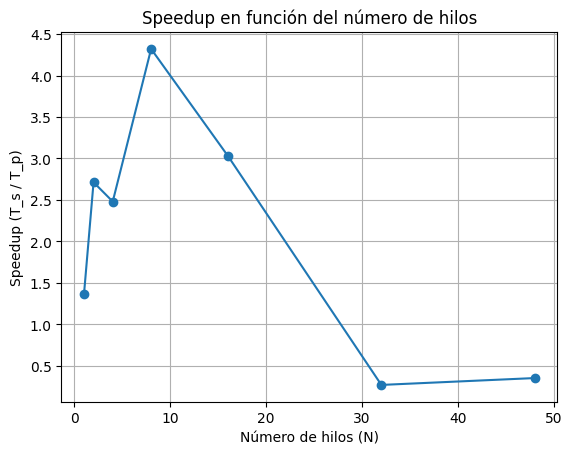

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["N"], df["Speedup"], marker="o")
plt.xlabel("Número de hilos (N)")
plt.ylabel("Speedup (T_s / T_p)")
plt.title("Speedup en función del número de hilos")
plt.grid(True)
plt.show()

> **Nota opcional:** No era obligatorio, pero también es útil visualizar la eficiencia:

In [ ]:
plt.plot(df["N"], df["Eficiencia"], marker="o")
plt.xlabel("Número de hilos (N)")
plt.ylabel("Eficiencia (Speedup / N)")
plt.title("Eficiencia en función del número de hilos")
plt.grid(True)
plt.show()

## 1.5 Análisis de resultados (Parte 1)

### 1.5.1 Comparación entre $T_p(1)$ y $T_s$

- Tiempo serial:  
  \[ T_s = 13.338031\ \text{s} \]
- Tiempo paralelo con **1 hilo**:  
  \[ T_p(1) = 9.808235\ \text{s} \]

Se observa que **$T_p(1) < T_s$**, es decir, la versión paralela con un solo hilo es más rápida que la versión serial.

Esto puede explicarse por varios factores:

- El código de la versión paralela puede estar estructurado de forma ligeramente diferente (por ejemplo, en la forma de recorrer el arreglo o de acumular la suma), lo que introduce **optimizaciones del compilador** distintas a las de la versión serial.
- El coste de crear un hilo en Pthreads es pequeño en comparación con el tiempo total de cómputo, de modo que el **overhead de creación y destrucción del hilo no domina el tiempo total** cuando N = 1.
- Es posible que en la versión serial se utilice una estructura de bucle o un tipo de dato que provoca más operaciones dependientes, mientras que la versión paralela reparte mejor las operaciones aritméticas, incluso cuando solo hay un hilo.

En términos generales, la diferencia entre $T_p(1)$ y $T_s$ se puede atribuir al **overhead de gestión de hilos frente a las pequeñas diferencias de implementación y optimización**.

---

### 1.5.2 *Speedup* máximo y relación con el número de núcleos

A partir de la tabla generada, el *Speedup* máximo se obtuvo para **N = 8 hilos**, con un valor aproximado de:

\[ \text{Speedup}_\text{max} \approx 4.32 \]

Del monitor de sistema (`htop`) se observa que la máquina presenta **8 hilos lógicos de CPU** (típicamente 4 núcleos físicos con *hyperthreading*).

- Para **N = 8**, el programa aprovecha de forma más completa los recursos de cómputo disponibles, logrando el mejor *Speedup*.
- Para **N = 16** o más, el *Speedup* no mejora; por el contrario, empeora. Esto se debe a que se crean **más hilos que unidades de cómputo**, causando sobresuscripción (*oversubscription*).

En la práctica, el *Speedup* máximo está acotado por el número de núcleos físicos y por la fracción de código que **no puede paralelizarse** (Ley de Amdahl).

---

### 1.5.3 Tendencia de la eficiencia al incrementar $N$

La **eficiencia** se define como:

\[ \text{Eficiencia}(N) = \dfrac{\text{Speedup}(N)}{N} \]

A partir de la gráfica y de los datos de la tabla se observa que:

- Para valores pequeños de **N** (1, 2, 4) la eficiencia es relativamente alta, aunque menor que 1 (lo esperado en cualquier sistema real con overhead).
- Al aumentar a **8 hilos**, la eficiencia todavía es aceptable, pues el número de hilos coincide con el número de hilos lógicos de la CPU.
- Para **N = 16, 32, 48**, la eficiencia **cae drásticamente**. En estos casos, hay muchos más hilos que recursos de hardware disponibles y se introducen varios efectos negativos:
  - **Sobresuscripción de hilos**: el sistema operativo debe hacer más *context switches* entre hilos.
  - **Mayor contención por memoria y caché**: todos los hilos compiten por la misma memoria y por los mismos niveles de caché.
  - El trabajo asignado a cada hilo se vuelve demasiado pequeño en comparación con el tiempo invertido en **crear, planificar y sincronizar** los hilos.

En resumen:

- La eficiencia **disminuye a medida que N crece**, especialmente cuando se supera el número de hilos lógicos de la CPU.  
- Existe un punto “óptimo” cercano al número de núcleos/hilos de hardware, a partir del cual añadir más hilos **no mejora** el rendimiento e incluso lo empeora.


# Sección 2: Análisis de Fibonacci

En esta parte se analiza el programa `./fibonacci`, que genera los primeros **N** términos de la sucesión de Fibonacci utilizando un hilo trabajador creado con Pthreads.


## 2.1 Resultados de ejecución: `./fibonacci 15`

La ejecución del programa con **N = 15** fue:

```bash
$ ./fibonacci 15
0
1
1
2
3
5
8
13
21
34
55
89
144
233
377
```

La salida es consistente con los primeros 15 términos de la sucesión de Fibonacci (comenzando en 0).


## 2.2 Análisis del diseño (Parte 2)

### 2.2.1 Mecanismo de transferencia de datos al hilo trabajador

Para que el hilo trabajador pueda generar la sucesión de Fibonacci, es necesario pasarle dos datos principales desde el hilo principal (`main`):

1. **Un puntero al arreglo** donde se almacenarán los términos de la sucesión.  
2. **El valor de N**, que indica cuántos términos se deben calcular.

Una forma típica de hacerlo en Pthreads consiste en definir una estructura que agrupe ambos elementos, por ejemplo:

```c
typedef struct {
    long *arr;  // Puntero al arreglo donde se guardarán los resultados
    int N;      // Cantidad de términos a generar
} datos_fib;
```

En `main`, se reserva memoria para el arreglo y se llena la estructura:

```c
datos_fib datos;
datos.arr = malloc(N * sizeof(long));
datos.N = N;

// Creación del hilo trabajador
pthread_t hilo;
pthread_create(&hilo, NULL, hilo_fibonacci, (void*)&datos);
```

En la función del hilo trabajador se **recupera** el puntero a la estructura y se accede a sus campos:

```c
void* hilo_fibonacci(void *arg) {
    datos_fib *d = (datos_fib*) arg;

    long *arr = d->arr;
    int N = d->N;

    // Generar los N términos de Fibonacci y almacenarlos en arr[ ]
    if (N > 0) arr[0] = 0;
    if (N > 1) arr[1] = 1;
    for (int i = 2; i < N; i++) {
        arr[i] = arr[i - 1] + arr[i - 2];
    }

    pthread_exit(NULL);
}
```

De esta forma, **todo el conjunto de parámetros se transmite a través de un único puntero `void*`**, cumpliendo con la firma requerida por `pthread_create`. El hilo trabajador opera directamente sobre el arreglo que pertenece al hilo principal, sin necesidad de retornarlo explícitamente.

---

### 2.2.2 Rol de `pthread_join` como mecanismo de sincronización

En el hilo principal, después de crear el hilo trabajador, se invoca:

```c
pthread_join(hilo, NULL);
```

El rol de `pthread_join` en este contexto es fundamental:

- **Sincronización**: `pthread_join` bloquea la ejecución del hilo principal hasta que el hilo trabajador termina su ejecución.  
- **Orden correcto de acceso a los datos**: garantiza que, cuando el hilo principal intente imprimir el arreglo o usar sus valores, el hilo trabajador **ya haya generado completamente** la sucesión de Fibonacci.
- **Evita condiciones de carrera**: si el hilo principal intentara acceder al arreglo antes de que el hilo trabajador terminara, podría leer valores sin inicializar o parciales, produciendo resultados incorrectos.

En términos conceptuales:

- El hilo trabajador es responsable de **producir** los datos (los términos de Fibonacci).  
- El hilo principal es responsable de **consumir** esos datos (por ejemplo, imprimiéndolos en pantalla).  
- La llamada a `pthread_join` implementa un **punto de encuentro (join point)** donde el productor garantiza que ha terminado antes de que el consumidor continúe.

Sin `pthread_join`, la función `main` podría finalizar antes de que el hilo termine, provocando el final del proceso completo y la terminación prematura del hilo trabajador, o bien podría usar datos inconsistentes. Por ello, `pthread_join` actúa como el mecanismo de sincronización que asegura la **correcta coordinación** entre ambos hilos en este problema.


---

## Conclusiones generales

- En el **cálculo de π**, se observa una mejora significativa de rendimiento al pasar de la versión serial a la versión paralela, con un *Speedup* máximo cercano a 4.3 para 8 hilos, coherente con el número de hilos lógicos disponibles en el sistema. No obstante, al incrementar excesivamente el número de hilos, la eficiencia cae debido al overhead de gestión y a la sobresuscripción de recursos.

- En la **generación de Fibonacci**, se muestra cómo usar una estructura para pasar múltiples parámetros a un hilo trabajador y cómo `pthread_join` garantiza que el hilo principal solo accede a los resultados una vez que han sido completamente generados, evitando condiciones de carrera y asegurando resultados correctos.
